<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## Conditional GAN Demonstration

#### Honggeun Jo, PhD Student, The University of Texas at Austin

##### [LinkedIn](https://www.linkedin.com/in/honggeun-jo/?originalSubdomain=kr) | [GitHub](https://github.com/whghdrms) | [Twitter](https://twitter.com/HonggeunJ)

#### Wen Pan, Graduate Candidate, The University of Texas at Austin

##### [LinkedIn](https://www.linkedin.com/in/wen-pan/) 

#### Javier E. Santos, Graduate Candidate, The University of Texas at Austin

##### [LinkedIn](https://www.linkedin.com/in/je-santos/) | [GitHub](https://github.com/je-santos) | [Twitter](https://twitter.com/javier_e_santos?lang=en)

#### Michael Pyrcz, Associate Professor, University of Texas at Austin 

##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1) | [GeostatsPy](https://github.com/GeostatsGuy/GeostatsPy)


### Workflow for Training Unconditional and Conditional GANs

In this workflow, we demonstrate and compare unconditional (regular) GANs [(Goodfellow et al., 2014)](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)and conditional GANs [(Mirza and Osindero, 2014)](https://arxiv.org/abs/1411.1784) trained with the Modified National Institute of Standards and Technology (MNIST) database of hand written images of integers. 

The MNIST database includes:

* 60,000 training images and 10,000 testing images

* grey-scale 2D, exhaustive images of 28x28 pixels in size

* labeled as integers 0, 1, 2,..., 9


We build 2 models for making "fake" integers

* Model 1. Unconditional GAN for MINST pooling all digit together without labels

* Model 2. Conditional GAN for MINST integrating the integer labels


#### Import Packages 

Fist of all, we need to load the required libraries, such as 

* [numpy](https://numpy.org/): To generate arrays <br>
* [matplotlib](https://matplotlib.org/): Vilsualization purpose <br>
* [tensorflow > 2.0.0](https://www.tensorflow.org/learn): Design, compile and train neural network models
* os: to update working directory 
* time: to measrue compute time 

We also set the random number seeds for the NumPy and TensorFlow packages to ensure repeatability of the results.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import pandas as pd
import seaborn as sns
from tensorflow.keras.models import load_model # this is for loading NN models 

# Be sure that you have tensorflow > 2.0 version
assert tf.__version__.startswith('2.') # This will give you error if tensorflow < 2.0
# Default float to be 'float32' (So far, Tensorflow only works with float8, 16, 32)
tf.keras.backend.set_floatx('float32')
# Fix random seed for tensorflow / numpy 
tf.random.set_seed(77777)
np.random.seed(77777)

#### Make the Working / Storage Directories

We make directories to save the trained model and training snapshots from the generator model.

In [4]:
# This is for making directories where to save trained model and snapshots:
Directory_name_ = 'Conditional GAN'               # make the directory for the trained model
if os.path.isdir(Directory_name_) == False:
    os.mkdir(Directory_name_)          
if os.path.isdir('Snapshots') == False:           # make the directory for modeling training snapshots   
    os.mkdir('Snapshots')

#### Load the Training Data from The MNIST Image Database

The MNIST integer database is available with the Tensorflow package in the keras module.

* **x** - is the images
* **y** - is the respective integer labels

In [5]:
# Load CIFAR10: https://www.cs.toronto.edu/~kriz/cifar.html
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


#### Check the Image Data

Confirm the size of the training and testing data

* should be 60,000 training data and 10,000 testing data (images with labels).

Given a number of rows (r) and columns (c), visualize the first c $\times$ r images.

The number of training data: 60000 
The number of testing data: 10000


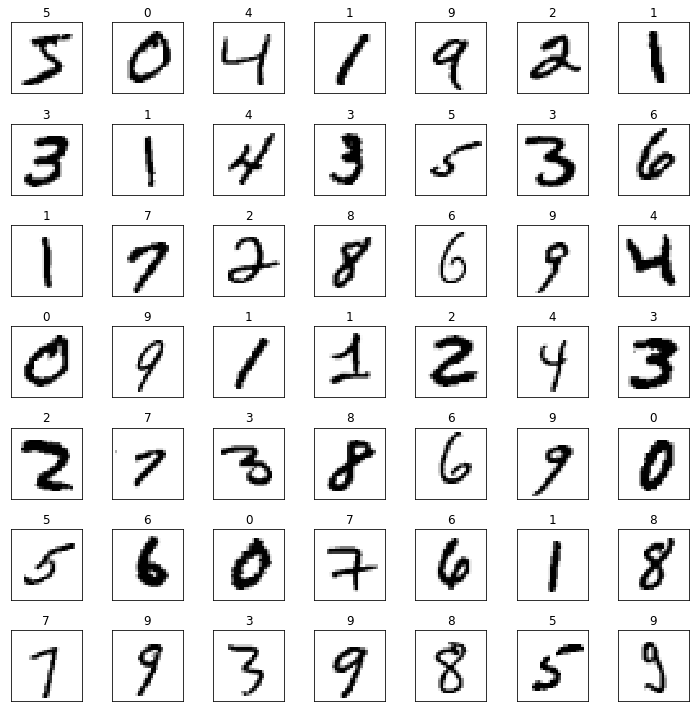

In [9]:
# Visualizae MPS realizations from the above training image:
print(f'The number of training data: {x_train.shape[0]} \nThe number of testing data: {x_test.shape[0]}')

# Visualize training images:
c, r = 7, 7                                         # number of columns and rows
plt.figure(figsize = (10,10))                       # initialize the stacked plot and set the size 
for i in range(c*r):                                # loop over all columns and rows
    plt.subplot(c,r,i+1)
    fig = plt.imshow(x_train[i], cmap = 'binary')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.title(y_train[i])
plt.tight_layout()

Now we are ready to start building and training our GANs.

#### Model 1. Unconditional GAN / Regular GAN

First we need to define the structure of Generative Adversarial Network (GAN) to learn the main pattern from the above hand written interger training images. Following figure shows the schematic diagram of the GAN architecture. 

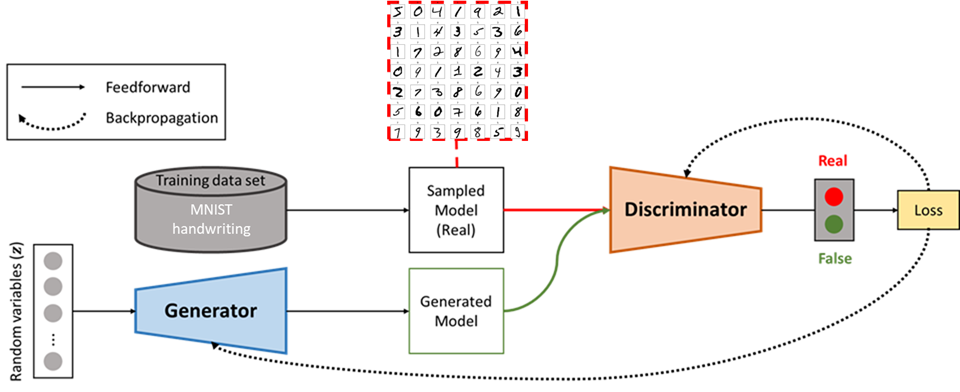

Here, both **Generator** and **Discriminator** are convolutional neural networks. 

* **Generator** maps a latent random vector (consists of 100 random variables that follow Gaussian, N(0,1)) to rule-based model whose dimension is 128 x 128 grid cells in x- and y- direction. 

* **Discriminator** takes a subsurface model (from either dataset or generator) and compute the probability the input model to be realistic (i.e., having major patterns within training dataset.) 

The following includes functions:

* **generator** - the convolutional neural network that makes new images

* **discriminator** - the convolutional neural network that takes images and accesses their probability that they came from the training image set

* **GAN** - the coupled generator and discriminator

* **train** - the procedure for training the GAN storing results

#### Build the Generator Function

Design CNN to map a random latent vector to the synthetic (fake) image

* latent vector length of 100 to a image 

In [13]:
def make_generator_model():
    model = tf.keras.Sequential()
    # Feature map 1: 100 --> (7x7x64), where (width x height x # of channel)
    model.add(layers.Dense(7*7*128, input_shape=(25,)))  # This input dimension can be adjusted depends of the complexity
    model.add(layers.Reshape((7, 7, 128)))
    # Feature map 2: (7x7x128) --> (14x14x128)
    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2,2), padding = "same"))
    model.add(layers.ReLU())
    # Feature map 3: (14x14x128) --> (28x28x128)
    model.add(layers.Conv2DTranspose(16, kernel_size=(4, 4), strides=(2,2), padding = "same"))
    model.add(layers.ReLU())
    # Feature map 4: (28x28x128) --> (28x28x1)
    model.add(layers.Conv2D(1, kernel_size=(7,7), padding="same", activation = 'tanh'))
    return model

#### Build the Discriminator Function

Design CNN to map a image to the likelihood to be true. 

* target output = 1 if real (image from the training dataset)

* target output = 0 if synthetic / fake (image from the generator) 

In [14]:
def make_discriminator_model():
    # define neural network model sequentially
    model = tf.keras.Sequential()
    # Feature map 1: (28x28x1) --> (14x14x128)
    model.add(layers.Conv2D(128, kernel_size=(3,3), strides=2, input_shape=[28,28,1], padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))
    # Feature map 2: (14x14x128) --> (7x7x128)
    model.add(layers.Conv2D(128, kernel_size=(3,3), strides=2, padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))
    # Feature map 3: (7x7x32) --> 1 (either 1 (for real) or 0 (for fake))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(1,activation = 'sigmoid'))
    return model

#### Define the Loss, Optimizers and Training

The following fucntions are the building blocks for our regular GAN

* loss and optimizers for the generator and descriminator
* training steps
* training Epochs composed of training steps
* save generator images periodically to evaluate progress
* save the trained model

In [15]:
## Define the loss and optimizers
# Loss fuction of GAN:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Optimizer of Generator and Discriminator (both "Adam")
generator_optimizer = tf.keras.optimizers.Adam(0.0002,0.5)  # Adam with specified learning rage and beta_1
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002,0.5)

## Define functions to train the GAN
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    # Noise (i.e., latent random variables) for fake images 
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    # ------------------------------------------------
    # 0. Compute of loss in generator and discriminator
    # ------------------------------------------------
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # generator random images
        generated_images = generator(noise, training=True)
        # output of discriminator when feeding real images
        real_output = discriminator(images, training=True)
        # output of discriminator when feeding fake images
        fake_output = discriminator(generated_images, training=True)
        # Compute both loss of generator and discriminator
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    # ------------------------------------------------
    # 1. Update Generator
    # ------------------------------------------------
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    # ------------------------------------------------
    # 2. Update Discriminator
    # ------------------------------------------------
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

def train(dataset, epochs):
    start = time.time()
    Loss_G = []
    Loss_D = []
    for epoch in range(epochs):
        # Train GAN on Batches
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            Loss_G.append(gen_loss); Loss_D.append(disc_loss)
        # Save the model every 50 epochs
        if (epoch) % 100 == 0:
            save_model(generator, epoch)
            save_imgs(generator, epoch, test_input = seed)
            print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
            start = time.time()
    return Loss_G, Loss_D

# This is to save snapshot of images from generator
def save_imgs(generator, epoch, test_input):
    # r, c = row and columns of the subplot
    r, c = 5, 5
    noise = test_input
    # Generate 25 new images with the given seed
    gen_imgs = generator(noise, training=False)
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='binary')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("Snapshots/GAN_epoch_%d.png" % epoch)
    plt.close()

# This is to save the trained generators
def save_model(generator, epoch):
    generator.save(Directory_name_ + '/Generator_Epoch_%d.h5' % epoch)


#### Instantiate the GAN

With the make_generator_model() and make_discriminator_model() functions.

In [16]:
# Instantiate generator and discriminator
generator = make_generator_model()
discriminator =  make_discriminator_model()

#### Set the Number of Epochs and Training Visualization 

Here we set the the following:

* **noise_dim** - the dimension of the random latent feature vector
* **number_of_examples_to_generate** - number of random models from the generator to visaulize in the snapshots

In [18]:
# Define number of epochs with seed to visualize training process
noise_dim = 25
num_examples_to_generate = 100
# We will reuse this seed overtime to visualize progress in training
seed = tf.random.normal([num_examples_to_generate, noise_dim])

#### Set the Training Paramaters

* training **EPOCHS** - cycles over all the training images segmented into batches
* **BUFFER_SIZE** - number of training samples in the shuffle buffer
* **BATCH_SIZE** - number of training samples applied for each training cycle

In [20]:
# Batch and shuffle the data
EPOCHS = 1001
BUFFER_SIZE = 5000
BATCH_SIZE = 2000
x_train_ = np.expand_dims(x_train[:10000], 3)
x_train_ = (x_train_ - 127.5)/127.5 # min max normalize the image intensities from [0,256] to [0,1]
train_dataset = tf.data.Dataset.from_tensor_slices(x_train_).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

#### Train the GAN

In [ ]:
# Train GAN
Loss_G, Loss_D = train(train_dataset, EPOCHS)

Time for epoch 1 is 14.377628803253174 sec
Time for epoch 101 is 1346.1917669773102 sec


#### GAN Quality Check

Visualize the Loss Function for Generator and Discriminator over training Epochs

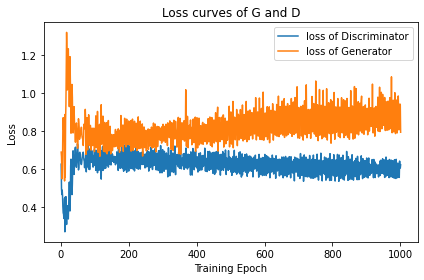

In [ ]:
# Visualize Loss curve:
loss_g = np.array(Loss_G).reshape(EPOCHS,-1)
loss_d = np.array(Loss_D).reshape(EPOCHS,-1)
loss_g = np.mean(loss_g, axis = -1)
loss_d = np.mean(loss_d, axis = -1)

plt.plot(np.arange(1,1002,1), loss_d/2, label = 'loss of Discriminator')
plt.plot(np.arange(1,1002,1), loss_g, label = 'loss of Generator')
plt.legend()
plt.xlabel('Training Epoch');
plt.ylabel('Loss')
plt.title('Loss curves of G and D')
plt.tight_layout()

#### Load and Demonstrate the Generator

Load the generator and then make the latent features to pass:

* a random standard Gaussian array $[100 \times 25]$

* 100 example models

* 25 random values for the latent features to make each model

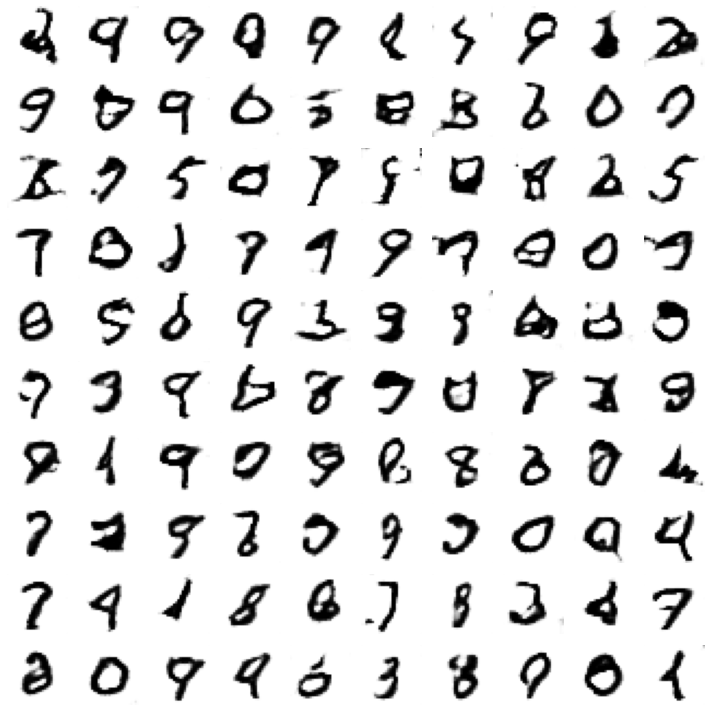

In [ ]:
# Load and demonstrate Generator
Generator = load_model(Directory_name_+'/Generator_Epoch_1000.h5', compile = False)
GAN_realization = Generator.predict(np.random.normal(0,1,(100,25))).reshape(100,28,28)

plt.figure(figsize = (10,10))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.axis('off')
    plt.imshow(GAN_realization[i, :,:], cmap='binary')
plt.tight_layout()

#### Visualize the Lower Dimensionality Projection

* Multidimensional scaling to project to 2D
* ocmpare the training data and synthetic (fake) images from the trained generator

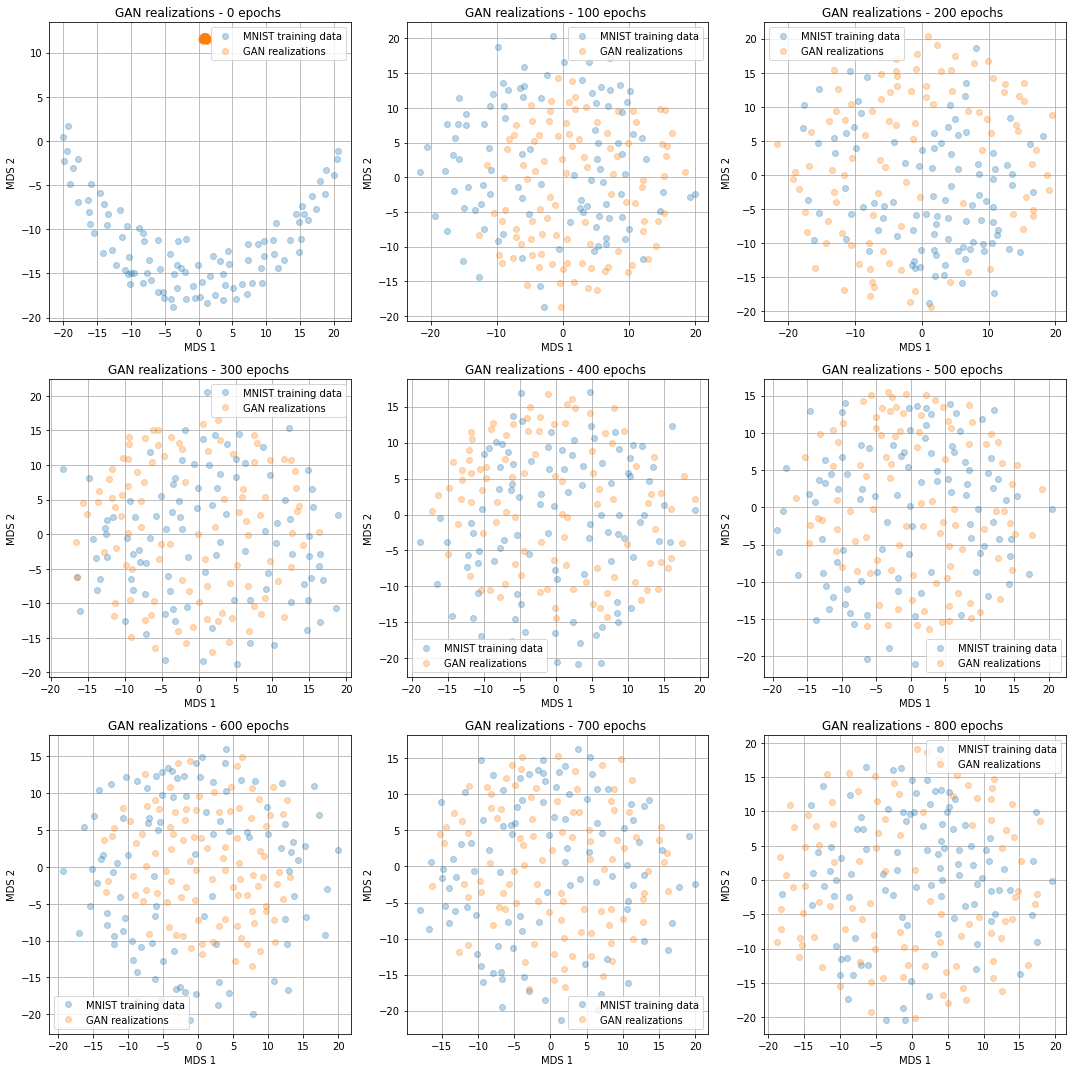

In [ ]:
# Quality Check
# Visualize similarity in 2D space (MDS)
from sklearn.manifold import MDS
mds = MDS(random_state=123)
mnist_realizations = x_train_[:100].reshape(100,-1)

plt.figure(figsize=(15,15))
epochs = [i*100 for i in range(0,10)]
for i in range(9):
    # Map to 2D space
    Generator = load_model(Directory_name_+'/Generator_Epoch_%d.h5' % epochs[i], compile = False)
    GAN_realizations = Generator.predict(np.random.normal(0,1,(100,25))).reshape(100,-1)
    mds_array = np.concatenate([mnist_realizations, GAN_realizations], axis = 0)
    mds_2D = mds.fit_transform(mds_array)
    
    plt.subplot(3,3,i+1)
    plt.plot(mds_2D[:100,0],mds_2D[:100,1],'o', alpha = 0.3, label = 'MNIST training data')
    plt.plot(mds_2D[100:,0],mds_2D[100:,1],'o', alpha = 0.3, label = 'GAN realizations')
    plt.title('GAN realizations - %d epochs ' %(epochs[i]))
    plt.grid('on')
    plt.xlabel('MDS 1')
    plt.ylabel('MDS 2')
    plt.legend()
    
plt.tight_layout()

The above MDS plots indicates that GAN realizations become more and more similar to the training data as the GAN trains. 

* after 500 epochs, two clusters (i.e., red - GAN and blue - MNIST) merge into one and they are becomes indistinguishable. 

* this indicates that the GAN is successfully trained to generate realistic hand writing image. 

However, as this GAN is **unconditional**, we have no control to make the generated images to be a specific label (e.g., 1, 2, 3, ... 9). In the following sections, we will continue to the conditional GAN, which we can incorporate the label.   

#### Model 2. Conditional GAN 

Now we need to define the structure of the conditional Generative Adversarial Network (cGAN) to learn the main pattern from the above hand written interger training images. Following figure shows the schematic diagram of the GAN architecture. 

Here, both **Generator** and **Discriminator** are convolutional neural networks. 

* **Generator** maps a latent random vector (consists of 100 random variables that follow Gaussian, N(0,1)) to rule-based model whose dimension is 128 x 128 grid cells in x- and y- direction. 

* **Discriminator** takes a subsurface model (from either dataset or generator) and compute the probability the input model to be realistic (i.e., having major patterns within training dataset.) 

The following includes functions:

* **generator** - the convolutional neural network that makes new images

* **discriminator** - the convolutional neural network that takes images and accesses their probability that they came from the training image set

* **GAN** - the coupled generator and discriminator

* **train** - the procedure for training the GAN storing results

* **label** - is the image labels ($0,1,\ldots,9) passed to the generator and descriminator

![image.png](attachment:image.png)

#### Build the Generator and Discriminator Function

Just like previous step, both **Generator** and **Discriminator** are convolutional neural networks. 

* only difference is that both **Generator** and **Discriminator** take labels (i.e., 0, 1, 2, 3, ...) in addition to their original inputs. 

* in this way, we can train **Conditional GAN**, which only generates images that follows the given labels. 

In [102]:
def make_conditional_generator_model(latent_dim = 25, n_classes=10):
    # Input Label
    in_label = layers.Input(shape = (1,))
    li = layers.Embedding(n_classes, 50)(in_label)
    li = layers.Dense(7*7*1)(li)
    li = layers.Reshape((7,7,1))(li)
    in_label_model = models.Model(inputs = in_label, outputs = li)
    # Input latent variables
    in_latent = layers.Input(shape = (latent_dim,))
    gen = layers.Dense(128*7*7)(in_latent)
    gen = layers.LeakyReLU(0.2)(gen)
    gen = layers.Reshape((7,7,128))(gen)
    gen_model = models.Model(inputs = in_latent, outputs = gen)
    # Combine image + label input (i.e., concatenate)
    merge = layers.Concatenate()([gen_model.output, in_label_model.output])
    # Feature map 1: (7x7x128) --> (14x14x128)
    gen = layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2,2), padding = "same")(merge)
    gen = layers.LeakyReLU(0.2)(gen)
    # Feature map 2: (14x14x128) --> (28x28x128)
    gen = layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2,2), padding = "same")(gen)
    gen = layers.LeakyReLU(0.2)(gen)
    # Feature map 3: (28x28x128) --> (28x28x1)
    out_layer = layers.Conv2D(1, (7,7), activation='tanh', padding='same')(gen)   

    # Define Model
    model = models.Model(inputs = [gen_model.input, in_label_model.input], outputs=out_layer)

    return model

def make_conditional_discriminator_model(in_shape=(28,28,1), n_classes=10):
    # Input Label
    in_label = layers.Input(shape=(1,))
    li = layers.Embedding(n_classes, 50)(in_label)
    li = layers.Dense(28*28*1)(li)
    li = layers.Reshape((28,28,1))(li)
    in_label_model = models.Model(inputs = in_label, outputs = li)
    # Input Image
    in_image = layers.Input(shape=in_shape)
    in_image_model = models.Model(inputs = in_image, outputs = in_image)
    # Combine image + label input (i.e., concatenate)
    merge = layers.Concatenate()([in_image_model.output, in_label_model.output])
    # Feature map 1: (28x28x1) --> (14x14x128)
    fe = layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
    fe = layers.LeakyReLU(alpha=0.2)(fe)
    # Feature map 2: (14x14x128) --> (7x7x128)
    fe = layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = layers.LeakyReLU(alpha=0.2)(fe)
    # Feature map 3: (7x7x32) --> 1 (either 1 (for real) or 0 (for fake))
    fe = layers.Flatten()(fe)
    fe = layers.Dropout(0.4)(fe)
    out_layer = layers.Dense(1, activation = 'sigmoid')(fe)

    # Define Model
    model = models.Model([in_image_model.input, in_label_model.input], out_layer)

    return model

In [ ]:
#### Set the Number of Epochs and Training Visualization 

Here we set the the following:
* training **EPOCHS** - cycles over all the training images segmented into batches
* **noise_dim** - the dimension of the random latent feature vector
* **number_of_examples_to_generate** - number of random models from the generator to visaulize in the snapshots

In [104]:
# Define number of epochs with seed to visualize training process
EPOCHS = 1001
noise_dim = 25
num_examples_to_generate = 100
# We will reuse this seed overtime to visualize progress in training
seed = tf.random.normal([num_examples_to_generate, noise_dim])

#### Define the Loss, Optimizers and Training

The following fucntions are the building blocks for our regular GAN

* loss and optimizers for the generator and descriminator
* training steps
* training Epochs composed of training steps
* save generator images periodically to evaluate progress
* save the trained model

In [114]:
## Define the loss and optimizers
# Loss fuction of GAN:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Optimier of Generator and Discriminator (both "Adam")
generator_optimizer = tf.keras.optimizers.Adam(0.0002,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002,0.5)
## Define fuctions to train GAN
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images, true_labels):
    # Noise (i.e., latent random variables) for fake images 
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    label = np.repeat(np.array([i for i in range(0,10)]),int(BATCH_SIZE/10) ,axis = 0).reshape(BATCH_SIZE,1) 
    label = tf.convert_to_tensor(label, np.float32)   
    # ------------------------------------------------
    # 0. Compute of loss in generator and discriminator
    # ------------------------------------------------
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # generator random images
        generated_images = generator([noise, label], training=True)
        # output of discriminator when feeding real images
        real_output = discriminator([images, true_labels], training=True)
        # output of discriminator when feeding fake images
        fake_output = discriminator([generated_images, label], training=True)
        # Compute both loss of generator and discriminator
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    # ------------------------------------------------
    # 1. Update Generator
    # ------------------------------------------------
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    # ------------------------------------------------
    # 2. Update Discriminator
    # ------------------------------------------------
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

def train(dataset, epochs):
    start = time.time()
    Loss_G = []
    Loss_D = []
    for epoch in range(epochs):
        # Train GAN on Batches
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch['Image'], image_batch['Label'])
            Loss_G.append(gen_loss); 
            Loss_D.append(disc_loss)
        # Save the model every 50 epochs
        if (epoch) % 100 == 0:
            save_model(generator, epoch)
            save_imgs(generator, epoch, test_input = seed)
            print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
            start = time.time()
    return Loss_G, Loss_D

# This is to save snapshot of images from generator
def save_imgs(generator, epoch, test_input):
    # r, c = row and columns of the subplot
    r, c = 10, 10
    noise = test_input
    label = np.repeat(np.array([i for i in range(0,10)]), r, axis = 0).reshape(c*r,1) 
    label = tf.convert_to_tensor(label, np.float32)  
    # Generate 100 new images with the given seed + label
    gen_imgs = generator([noise, label], training=False)
    plt.figure(figsize=(10,10))
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='binary')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("Snapshots/Conditional_GAN_epoch_%d.png" % epoch)
    plt.close()

# This is to save the trained generators
def save_model(generator, epoch):
    generator.save(Directory_name_ + '/Conditional_Generator_Epoch_%d.h5' % epoch)


#### Instantiate and train the conditional GAN

With the make_generator_model() and make_discriminator_model() functions.

In [ ]:
# Instantiate generator and discriminator
generator = make_conditional_generator_model()
discriminator =  make_conditional_discriminator_model()

#### Set the Model Training Parameters

* **BATCH_SIZE** - number of training samples applied for each training cycle

In [115]:
# Batch and shuffle the data
BATCH_SIZE = 2000
x_train_ = np.expand_dims(x_train[:10000], 3)
x_train_ = (x_train_ - 127.5)/127.5   # min max normalize the image intensities from [0,256] to [0,1]
y_train_ = np.expand_dims(y_train[:10000], 1)

train_dataset = tf.data.Dataset.from_tensor_slices({'Image':x_train_, 'Label': y_train_}).batch(BATCH_SIZE)

#### Train the Conditional GAN

In [117]:
# Train GAN
Loss_G, Loss_D = train(train_dataset, EPOCHS)

here
Time for epoch 1 is 7.059581756591797 sec
here
Time for epoch 101 is 410.297611951828 sec
here
Time for epoch 201 is 408.7043173313141 sec
here
Time for epoch 301 is 408.78649854660034 sec
here
Time for epoch 401 is 409.16068267822266 sec
here
Time for epoch 501 is 408.67084193229675 sec
here
Time for epoch 601 is 409.2144730091095 sec
here
Time for epoch 701 is 408.4343614578247 sec
here
Time for epoch 801 is 408.2531349658966 sec
here
Time for epoch 901 is 408.4901626110077 sec
here
Time for epoch 1001 is 409.3680474758148 sec


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

#### GAN Quality Check

Visualize the Loss Function for Generator and Discriminator over training Epochs

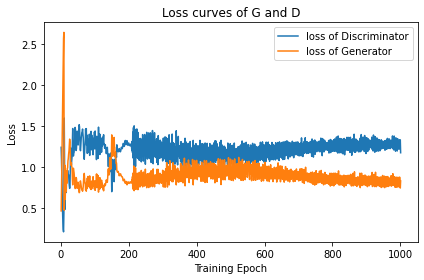

In [119]:
# Visualize Loss curve:
loss_g = np.array(Loss_G).reshape(EPOCHS,-1)
loss_d = np.array(Loss_D).reshape(EPOCHS,-1)
loss_g = np.mean(loss_g, axis = -1)
loss_d = np.mean(loss_d, axis = -1)

plt.plot(np.arange(1,1002,1), loss_d, label = 'loss of Discriminator')
plt.plot(np.arange(1,1002,1), loss_g, label = 'loss of Generator')
plt.legend()
plt.xlabel('Training Epoch');
plt.ylabel('Loss')
plt.title('Loss curves of G and D')
plt.tight_layout()

#### Load and Demonstrate the Generator

Load the generator and then make the latent features to pass:

* a random standard Gaussian array $[100 \times 25]$

* 100 example models

* 25 random values for the latent features to make each model

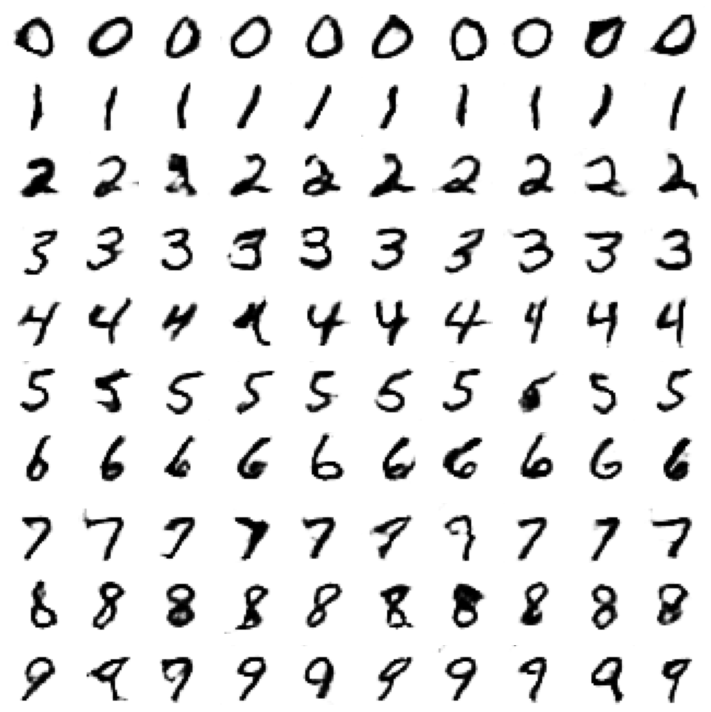

In [122]:
# Load and demonstrate Generator
Generator = load_model(Directory_name_+'/Conditional_Generator_Epoch_1000.h5', compile = False)
label = np.repeat(np.array([i for i in range(0,10)]), 10, axis = 0).reshape(10*10,1) 
GAN_realization = Generator.predict([np.random.normal(0,1,(100,25)), label]).reshape(100,28,28)

plt.figure(figsize = (10,10))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.axis('off')
    plt.imshow(GAN_realization[i,:,:], cmap='binary')
plt.tight_layout()

#### Visualize the Lower Dimensionality Projection

* Multidimensional scaling to project to 2D
* compare the training data and synthetic (fake) images from the trained generator

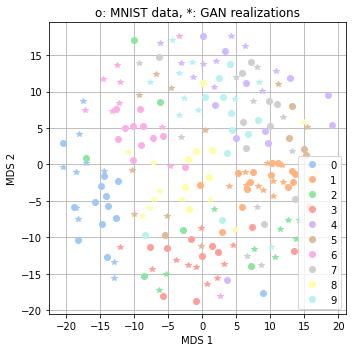

In [137]:
# Visualize similarity in 2D space (MDS)
from sklearn.manifold import MDS
mds = MDS(random_state=123)
mnist_realizations = x_train_[:100].reshape(100,-1)
mnist_label = y_train_[:100]

# Map to 2D space
Generator = load_model(Directory_name_+'/Conditional_Generator_Epoch_1000.h5', compile = False)
label = np.repeat(np.array([i for i in range(0,10)]), 10, axis = 0).reshape(10*10,1) 
GAN_realizations = Generator.predict([np.random.normal(0,1,(100,25)),label]).reshape(100,-1)
mds_array = np.concatenate([mnist_realizations, GAN_realizations], axis = 0)
mds_2D = mds.fit_transform(mds_array)

mds_2D_minst, mds_2D_gan =  mds_2D[:100], mds_2D[100:];
plt.figure(figsize=(5,5))
plt.title('o: MNIST data, *: GAN realizations')
for i in range(10):
    plt.plot(mds_2D_minst[mnist_label.flatten() == i,0],mds_2D_minst[mnist_label.flatten() == i,1], 'o', color = sns.color_palette("pastel")[i], label =str(i))
    plt.plot(mds_2D_gan[label.flatten() == i,0],mds_2D_gan[label.flatten() == i,1], '*', color = sns.color_palette("pastel")[i])
plt.grid('on')
plt.xlabel('MDS 1')
plt.ylabel('MDS 2')
plt.legend()

plt.tight_layout()

As shown the above graph, the conditional GAN successfully replicate MNIST hand writing data. 

* the GAN realizations are located in the cluster of MNIST data with the same label (e.g., 0, 1, 2, ...,9, visualized in different colors). 

* we can conclude that the trained conditional GAN generates images that are consistent with the input contioning information.

* note, 1's and 2's are similar and adjacent above, 8's are in the middle and simlar with other numbers.

#### Comments

The Texas Center for Geostatistics has many other demonstrations on the basics of working with DataFrames, ndarrays, univariate statistics, plotting data, declustering, data transformations, trend modeling and many other workflows available [here](https://github.com/GeostatsGuy/PythonNumericalDemos), along with a package for geostatistics in Python called [GeostatsPy](https://github.com/GeostatsGuy/GeostatsPy). 
  
We hope this was helpful,

*Michael*, *Honggeun*, *Javier* and *Wen*

***

#### More on Michael Pyrcz and the Texas Center for Data Analytics and Geostatistics:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)


### for any further comments or questions, please contact Dr. Pyrcz via mpyrcz@austin.utexas.edu